<center><h1>Introduction to Probabilistic Graphical Models</h1>
    <h2>Practical Session 2</h2>
    <h3>Aymen DABGHI</h3></center>

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sns
sns.set()

## Question 1 :

The GMM_i function implemented below computes $l_i$ given the parameters $i,x,K,\mu,\Sigma,\Pi$  

$\begin{align}
l_i &= \log[\Pi_i\mathcal{N}(x;\mu_i,\Sigma_i)] \\
&= \log(\Pi_i)-\frac{d}{2}\log(2\pi)-\frac{1}{2}\log(\det\Sigma_i)-\frac{1}{2}(x-\mu_i)^T\Sigma_i^{-1}(x-\mu_i)
\end{align}$

In [86]:
def GMM_i(i , x , K , mu , sigma , pi):
    d = len(x)
    aux = ((x-mu[i]).T).dot(np.linalg.inv(sigma[i])).dot(x-mu[i])
    l = np.log(pi[i]) - 0.5 * d * np.log(2*np.pi) - 0.5 * np.log(np.linalg.det(sigma[i])) - 0.5 * aux
    
    return l

While the GMM_sum function computes the log of the denominator of $\gamma_i(x)$ given the parameters $x,K,\mu,\Sigma,\Pi$  

$\begin{align}
\log\sum_{j=1}^{K}\Pi_j\mathcal{N}(x;\mu_j,\Sigma_j)
= v_m+\log\sum_{j=1}^{K}\exp(v_j-v_m)
\quad\quad \text{with $v_{max}=\max_i(v_i)$}
\end{align}$

In [87]:
def GMM_sum(x , K , mu , sigma , pi):
    res = 0
    d = len(x)
    aux = [GMM_i(i , x , K , mu , sigma , pi) for i in range(K)]
    v_max = max(aux)
    res = np.sum(np.exp(aux-v_max))
    
    return v_max + np.log(res)

Finally, the gamma_i function computes $\gamma_i(x)$ given the parameters $i,x,K,\mu,\Sigma,\pi$ and using the 2 functions implemented above.

In [88]:
def gamma_i(i , x , K , mu , sigma , pi):
    
    return np.exp(GMM_i(i , x , K , mu , sigma , pi) - GMM_sum(x , K , mu , sigma , pi))

## Question 2 :

In [90]:
def m_step(x , K , N , mu , sigma , pi):
    
    # The m_step function will return gamma, mu, sigma and pi after only one iteration of the algorithm

    gamma = np.array([np.array([gamma_i(j, x[n] , K , mu , sigma ,pi) for n in range(N)]) for j in range(K)])

    sum_gamma = np.sum(gamma , axis=1)
    
    mu = np.array([np.array(sum(gamma[j,n] * x[n] for n in range(N)) / sum_gamma[j]) for j in range(K)])
    
    sigma = np.array([np.array(sum(gamma[j,n] * np.outer(x[n]-mu[j] , x[n]-mu[j]) for n in range(N)) 
                               / sum_gamma[j]) for j in range(K)])
    
    pi = 1./N * sum_gamma
    
    return gamma , mu , sigma , pi

## Question 3 :
### 1)

In [135]:
# Setting the parameters that we're going to use

K = 3
N = 1000
pi = np.array([0.3 , 0.2 , 0.5])
mu = np.array([[0,0],[1,2],[2,0]])
sigma = np.array([[[1,-0.25],[-0.25,0.5]] , [[0.5,0.25],[0.25,0.5]] , [[0.5,-0.25],[-0.25,1]]])
x = np.concatenate([np.random.multivariate_normal(mu[i] , sigma[i] , size=int(pi[i]*N)) for i in range(K)])
x = np.array(x)

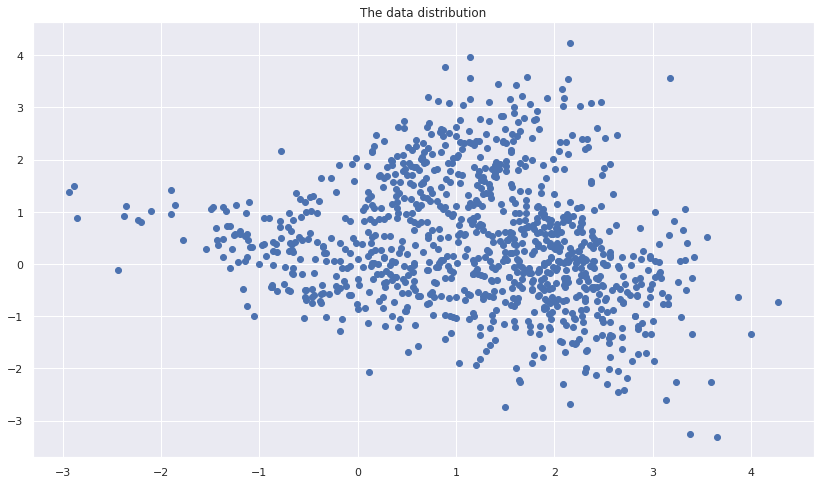

In [148]:
plt.figure(figsize=(14,8))
plt.scatter(x[:,0],x[:,1])
plt.title("The data distribution")
plt.show()

### 2)
#### a)

In [142]:
# Initializing the parameter estimates

pi_0 = [1./K] * 3
mu_0 = np.random.uniform(np.amin(x) , np.amax(x) , size=(3,2))
sigma_0 = np.zeros((K,len(x[0]),len(x[0])))
for dim in range(len(sigma_0)):
    np.fill_diagonal(sigma_0[dim],2)

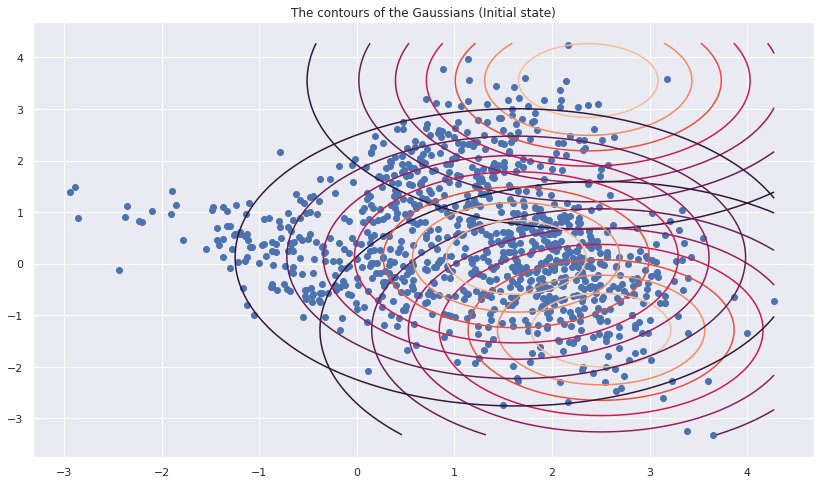

In [147]:
# Visualizing the contours of the estimated Gaussians with the pi_0, mu_0 and sigma_0 (Initial state)

plt.figure(figsize=(14,8))
a_max = np.amax(x)
a_min = np.amin(x)
X = np.linspace(a_min, a_max, 100)
Y = np.linspace(a_min, a_max, 100)
X, Y = np.meshgrid(X, Y)
pos = np.dstack((X, Y))
for i in range(K):
    rv = multivariate_normal(mu_0[i], sigma_0[i])
    plt.contour(X, Y, rv.pdf(pos))
plt.scatter(x[:,0] , x[:,1])
plt.title("The contours of the Gaussians (Initial state)")
plt.show()

In [161]:
def EM(x , K , N , T , mu , sigma , pi):
    
    # The EM function will return gamma, mu, sigma, pi, and the log lokelihood while plotting at each iteration 
    # the contours of the Gaussians
    
    fig = plt.figure(figsize=(14,80))
    log_likelihood = []
    
    for t in range(T):
        mu_ = mu
        sigma_ = sigma
        pi_ = pi
        gamma , mu , sigma , pi = m_step(x , K , N , mu_ , sigma_ , pi_)
        
        # Visualizing the intermediate results by plotting the contours of the estimated Gaussians
        # Since the algorithm will probably need many steps to converge, 
        # we're going to plot the contours every 5 steps so the notebook won't be too charged.
        if (t%5==0):
            ax = fig.add_subplot(11,1,t/5+1)
            for i in range(K):
                rv = multivariate_normal(mu[i], sigma[i])
                ax.contour(X, Y, rv.pdf(pos))
            ax.scatter(x[:,0] , x[:,1])
            ax.set_title("The contours of the Gaussians in the iteration : " + str(t))
            
        # Computing the log-likelihood
        log_likelihood.append(sum([GMM_sum(x[n] , K , mu , sigma , pi) for n in range(N)]))
        
    return gamma , mu , sigma , pi , log_likelihood

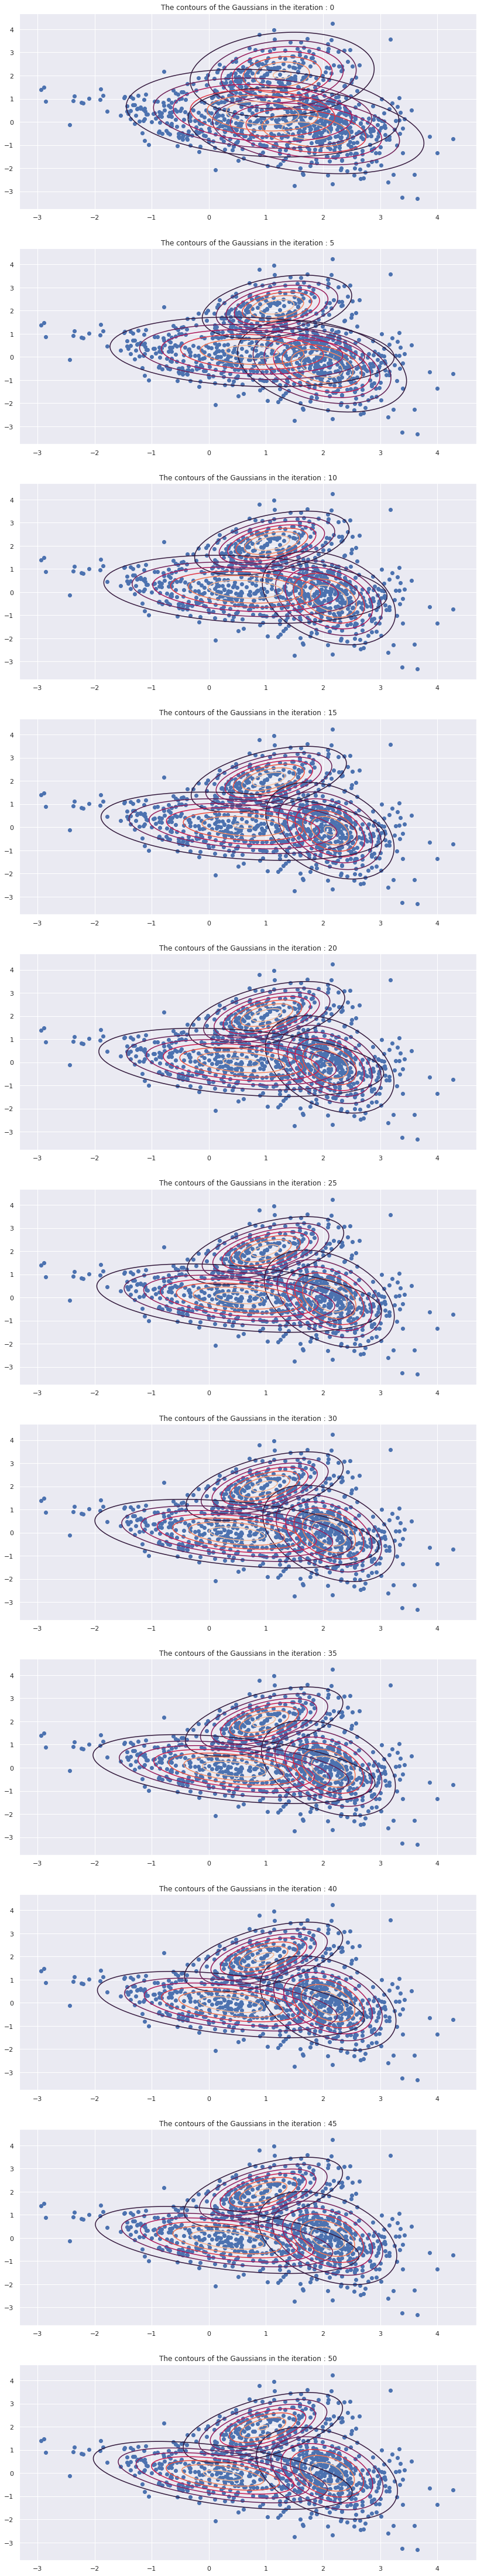

In [162]:
T = 51
gamma , mu , sigma , pi , log_ = EM(x , K , N , T , mu_0 , sigma_0 , pi_0)

After 50 iterations, we can clearly notice a change in the contours of the Gaussians towards the contours represented below (of the estimated Gaussians with the true parameters); meaning that the algorithm is converging to the optimum.

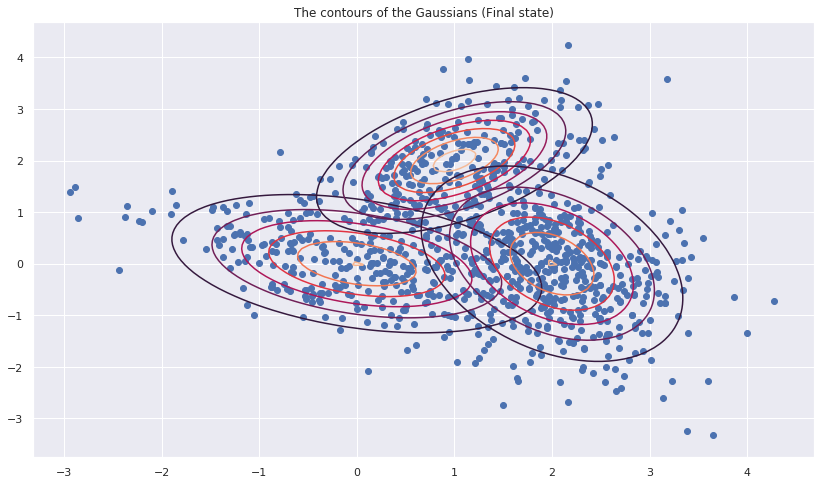

In [157]:
# Visualizing the contours of the estimated Gaussians with the model given in Q3

pi = np.array([0.3 , 0.2 , 0.5])
mu = np.array([[0,0],[1,2],[2,0]])
sigma = np.array([[[1,-0.25],[-0.25,0.5]] , [[0.5,0.25],[0.25,0.5]] , [[0.5,-0.25],[-0.25,1]]])

plt.figure(figsize=(14,8))

for i in range(K):
    rv = multivariate_normal(mu[i], sigma[i])
    plt.contour(X, Y, rv.pdf(pos))
plt.scatter(x[:,0] , x[:,1])
plt.title("The contours of the Gaussians (Final state)")
plt.show()

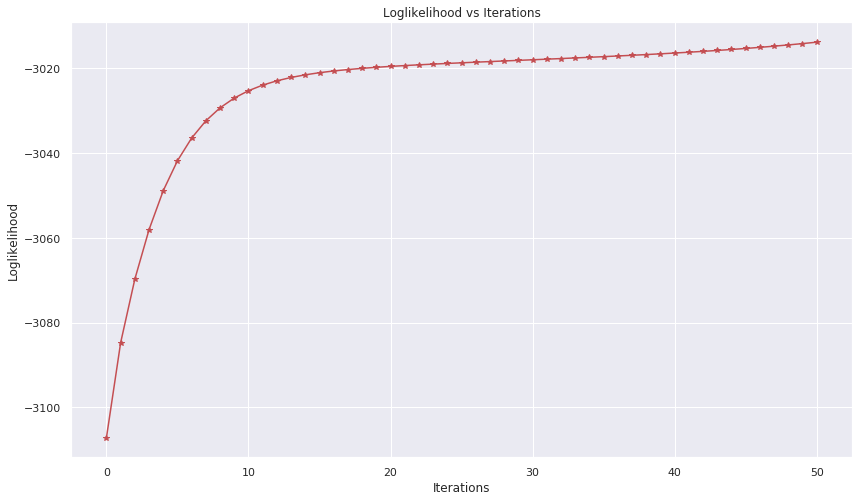

In [160]:
# Plotting the log likelihoos vs iterations

plt.figure(figsize=(14,8))
plt.title("Loglikelihood vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Loglikelihood")
plt.plot(log_ , 'r*-')

$\rightarrow$ The log likelihood function is negative and increasing which is expected.

#### c)  
If we run the EM algorithm with different initializations for $\pi_{1:K}^{(0)}, \mu_{1:K}^{(0)}$ and $\Sigma_{1:K}^{(0)}$, we will notice that different values of the log likelihood are returned. So we can say that the EM algorithm is sensitive for different initial values. In fact, the EM algorithm is considered as a local optimization method, and then particularly sensitive to the initialization of the model. It easily gets trapped in a local optimum. Therefore, the result returned depends on the initial parameters of the mixture model.